# Telemore-like content analysis of SRR11085797

"Analysis of RNA-Seq of Rhinolophus affinis:Fecal swab(SRR11085797)"

Experiment: SRX7724752
Run: SRR11085797

TelomereHunter was the most relevant package of those trialed including: Telomerecat, TelSeq, Computel as well a bespoke python implementation of Telomere exact pattern match

In [147]:

import time
import numpy as np
from Bio import SeqIO
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import pysam

In [8]:
DATA_PATH='/mnt/1TB_0/Data/RaTG13/analysis/'

## Telomerecat


[Telomerecat](https://telomerecat.readthedocs.io/en/latest/index.html)

Farmery, H.R., Smith, M.L., , Lynch, A.G. Telomerecat: A ploidy-agnostic method for estimating telomere length from whole genome sequencing data. bioRxiv Preprint. doi: https://doi.org/10.1101/139972 

Install telomerecat into conda python 3.6 environment

eg

```
conda create -n telomere python=3.6
conda activate telomere
pip install telomerecat
```


Generate telbam file using on previously formatted (aligned and indexed) bam file:

```
telomerecat bam2telbam Sars_SL3_171127_gatk_sorted_marked.bam -p 20 -v 1 --outbam_dir ../analysis/telomerecat
```

Calculate telomere lengths

```
telomerecat telbam2length ../../bwa/Sars_SL3_171127_gatk_sorted_marked.bam
```

"Too strict a definition of telomere as being the region of TTAGGG repeats would be hostage to genuine variations, sequencing errors, and somatic mutations"

-F1 read-pairs are comprised of two complete telomere reads. 
-F2a read-pairs are comprised of a read-pair where one read is complete telomere and the other is not. Crucially, the complete telomere read is comprised of CCCTAA
-An F4 read is read-pair where one read is complete telomere and the other is not. The complete end is comprised of TTAGGG (F2b is same but AATCCC

Telomere content was calculated by normalizing the number of extracted fully telomeric reads (“F1 reads”) to the total number of reads.


In [56]:
df_telcat=pd.read_csv(DATA_PATH+'telomerecat/telomerecat_length.csv')
df_telcat.head()

,Sample,F1,F2,F4,Psi,Insert_mean,Insert_sd,Read_length,Initial_read_length,F2a,F2a_c,Length
0,Sars_SL3_171127_gatk_sorted_marked.bam,3214739,1943088,1428867,2.526,274.448,161.223,151,151,514221,514221,1174.5


In [57]:
df_telcat.columns

Index(['Sample', 'F1', 'F2', 'F4', 'Psi', 'Insert_mean', 'Insert_sd',
       'Read_length', 'Initial_read_length', 'F2a', 'F2a_c', 'Length'],
      dtype='object')

In [60]:
telbam_records = list(SeqIO.parse(DATA_PATH+'telomerecat/Sars_SL3_171127_telbam_gatk_bamtools.fastq', "fastq"))
print(telbam_records[0])

ID: ST-J00123:84:hmn7ybbxx:6:1101:10003:14678/2
Name: ST-J00123:84:hmn7ybbxx:6:1101:10003:14678/2
Description: ST-J00123:84:hmn7ybbxx:6:1101:10003:14678/2
Number of features: 0
Per letter annotation for: phred_quality
Seq('CCTAACCCTAACCCTAACCCTATCCTGTTTTCAACCCTAACCCTAACCCCAACC...AAC')


Calculate telomere content using number of extracted fully telomeric reads (“F1 reads”) to the total number of reads in the sample

In [68]:
telcat_telcontent=df_telcat.iloc[0]['F1']/TOTAL_READS

In [69]:
print(f'Telomerecat telomere content: {telcat_telcontent*100}%')

Telomerecat telomere content: 13.851062150345387%


## TelomereHunter

Feuerbach, L., Sieverling, L., Deeg, K.I. et al. TelomereHunter – in silico estimation of telomere content and composition from cancer genomes. BMC Bioinformatics 20, 272 (2019). https://doi.org/10.1186/s12859-019-2851-0

-Reports telomere content rather than telomere length
-Classifies reads based on their mapping location within the parent BAM file and outputs statistics relating to variations of the canonic telomere hexamer


[TelomereHunter](https://www.dkfz.de/en/applied-bioinformatics/telomerehunter/telomerehunter.html)


Install telomerehunter into conda python 2.7 environment

telomerehunter version 1.1.0 was used for this analysis

eg

```
conda create -n bioinfo_py27 python=2.7
conda activate bioinfo_py27
pip install telomerehunter
```



### Pre processing

-Align reads using BWA

```
~/apps/bwa-0.7.17/bwa index /mnt/1TB_0/Data/fasta/MN996532_2_RaTG13_complete_genome.fa

~/apps/bwa-0.7.17/bwa mem /mnt/1TB_0/Data/fasta/MN996532_2_RaTG13_complete_genome.fa Sars_SL3_R1_171127.fastq Sars_SL3_R2_171127.fastq >../bwa/Sars_SL3_R2_171127_bwa_mem.sa
```

-Sorting and Duplicate marking usink GATK

```
java -jar ~/apps/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar  SortSam INPUT=Sars_SL3_171127_aln-pe.sam OUTPUT=Sars_SL3_171127_gatk_sorted.sam SORT_ORDER=coordinate VALIDATION_STRINGENCY=SILENT
```

-Mark duplicates, note we limit to 64GB ram

```
java -Xmx64G -jar ~/apps/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar  MarkDuplicates INPUT=Sars_SL3_171127_gatk_sorted.sam OUTPUT=Sars_SL3_171127_gatk_sorted_marked.bam METRICS_FILE=Sars_SL3_171127_gatk_markduplicates_metrics.txt ASSUME_SORTED=true VALIDATION_STRINGENCY=SILENT
```

### Run TelomereHunter

#### n = 6

-Using default repeat threshold of n=6 reads per 100 bp where "n is calculated for each read depending on the read length with the following formula: n = floor(read length · 0.06). The criterion of searching for six non-consecutive repeats in 100 bp long reads has been proposed previously (Lee, et al., 2014) and was also found suitable for the data presented in the present study.

```
telomerehunter -ibt Sars_SL3_171127_gatk_sorted_marked.bam -o ../analysis/telomerehunter -p Sars_SL3_171127_output
```

In [131]:
fpath=DATA_PATH+'telomerehunter/Sars_SL3_171127_default/Sars_SL3_171127_default_summary.tsv'
df_telhunt_n6=pd.read_csv(fpath, sep='\t')
df_telhunt_n6.head()

,PID,sample,total_reads,read_length,repeat_threshold_set,repeat_threshold_used,tel_reads,intratel_reads,gc_bins_for_correction,total_reads_with_tel_gc,...,TCAGGG_singletons_norm_by_all_reads,TGAGGG_singletons_norm_by_all_reads,TTGGGG_singletons_norm_by_all_reads,TTCGGG_singletons_norm_by_all_reads,TTTGGG_singletons_norm_by_all_reads,ATAGGG_singletons_norm_by_all_reads,CATGGG_singletons_norm_by_all_reads,CTAGGG_singletons_norm_by_all_reads,GTAGGG_singletons_norm_by_all_reads,TAAGGG_singletons_norm_by_all_reads
0,Sars_SL3_171127_default,tumor,23209332,"46,69,79,81,93,101,103,106,112,113,115,116,119...",6 per 100 bp,"3,4,5,6,7,8,9",12710959,12710959,48-52,8104506,...,0.000148,0.000164,0.000132,0.000156,0.000428,0.000433,0,0.000118,0.000103,0.000315


In [ ]:
TOTAL_READS=df_telhunt_n6.iloc[0]['total_reads']

In [132]:
fpath=DATA_PATH+'telomerehunter/Sars_SL3_171127_default/tumor_TelomerCnt_Sars_SL3_171127_default/Sars_SL3_171127_default_tumor_summary.tsv'
df_telhunt_tsum_n6=pd.read_csv(fpath, sep='\t')
df_telhunt_tsum_n6.head()

,PID,sample,total_reads,read_length,repeat_threshold_set,repeat_threshold_used,tel_reads,intratel_reads,gc_bins_for_correction,total_reads_with_tel_gc,tel_content
0,Sars_SL3_171127_default,tumor,23209332,"46,69,79,81,93,101,103,106,112,113,115,116,119...",6 per 100 bp,"3,4,5,6,7,8,9",12710959,12710959,48-52,8104506,1.568382e+06


In [156]:
df_telhunt_spec_n6=pd.read_csv(spectrum_file, sep='\t')

,chr,band,reads_with_pattern,TTAGGG,CCCTAA,TGAGGG,CCCTCA,TCAGGG,CCCTGA,TTGGGG,CCCCAA,other
906,Y,q11.223,0,0,0,0,0,0,0,0,0,0
907,Y,q11.23,0,0,0,0,0,0,0,0,0,0
908,Y,q12,0,0,0,0,0,0,0,0,0,0
909,Y,junction2,0,0,0,0,0,0,0,0,0,0
910,unmapped,unmapped,12710959,70601025,69879961,2555035,1579053,348852,236874,2418708,8160726,152317702


In [158]:
lr=df_telhunt_spec_n6.iloc[-1]
lr

chr                    unmapped
band                   unmapped
reads_with_pattern     12710959
TTAGGG                 70601025
CCCTAA                 69879961
TGAGGG                  2555035
CCCTCA                  1579053
TCAGGG                   348852
CCCTGA                   236874
TTGGGG                  2418708
CCCCAA                  8160726
other                 152317702
Name: 910, dtype: object

In [172]:
tel_gc_reads_n6=(df_telhunt6.iloc[0]['total_reads_with_tel_gc']/TOTAL_READS)*100
tel_reads_n6=(df_telhunt6.iloc[0]['intratel_reads']/TOTAL_READS)*100

In [173]:
print(f'Telomeric Reads with GC within 48–52% range: {tel_gc_reads_n6} ')
print(f'Telome content without GC correction: {tel_reads_n6}')

Telomeric Reads with GC within 48–52% range: 34.91916958230422 
Telome content without GC correction: 54.766586991818635
TelomereHunter telomere content: 6.757547837193247


### TelSeq

Zhihao Ding, Massimo Mangino, Abraham Aviv, UK10K Consortium, Tim Spector, Richard Durbin, Estimating telomere length from whole genome sequence data, Nucleic Acids Research, Volume 42, Issue 9, 14 May 2014, Page e75, https://doi.org/10.1093/nar/gku181

[Reference](https://academic.oup.com/nar/article/42/9/e75/1249448)

Installed docker container as per here

[git repo](https://github.com/zd1/telseq/)


docker run -v /mnt/1TB_0/Data/RaTG13/bwa/RG/Sars_SL3_171127_gatk_sorted_marked_RG.bam:/Sars_SL3_171127_gatk_sorted_marked_RG.bam telseq-docker /Sars_SL3_171127_gatk_sorted_marked_RG.bam 

Start analysing BAM /Sars_SL3_171127_gatk_sorted_marked_RG.bam


Output file format

|Column	        |Definitions                                                      |
|:--------------|-------------------------------------------------------------- -:|
|ReadGroup	    |read group, Defined by the RG tag in BAM header.                 |
|Library	    |sequencing library that the read group belongs to.               |
|Sample	        |defined by the SM tag in BAM header.                             |
|Total	        |total number of reads in this read group.                        |
|Mapped	        |total number of mapped reads, SAM flag 0x4.                      |
|Duplicates	    |total number of duplicate reads, SAM flag 0x400.                 |
|LENGH_ESTIMATE	|estimated telomere length.                                       |
|TEL0	        |read counts for reads containing no TTAGGG/CCCTAA repeats.       |
|TEL1	        |read counts for reads containing only 1 TTAGGG/CCCTAA repeats.   |
|TELn	        |read counts for reads containing only n TTAGGG/CCCTAA repeats.   |
|TEL16	        |read counts for reads containing 16 TTAGGG/CCCTAA repeats.       |
|GC0	        |read counts for reads with GC between 40%-42%.                   |
|GC1	        |read counts for reads with GC between 42%-44%.                   |
|GCn	        |read counts for reads with GC between (40%+n*2%)-(42%+(n+1)*2%). |
|GC9	        |read counts for reads with GC between 58%-60%.                   |


In [71]:
df_telseq=pd.read_csv(DATA_PATH+'telseq/telseq.csv')

In [72]:
df_telseq.head()

,ReadGroup,Library,Sample,Total,Mapped,Duplicates,LENGTH_ESTIMATE,TEL0,TEL1,TEL2,...,GC0,GC1,GC2,GC3,GC4,GC5,GC6GC7,GC8,GC9,Unnamed: 33
0,UNKNOWN,UNKNOWN,UNKNOWN,23209335,1951,237,14119.3,8975989,414071,40516,...,540572,625142,996052,2134937,3529977,2891274,2185561,1738696,1281209,799222


In [73]:
df_telseq.columns

Index(['ReadGroup', 'Library', 'Sample', 'Total', 'Mapped', 'Duplicates',
       'LENGTH_ESTIMATE', 'TEL0', 'TEL1', 'TEL2', 'TEL3', 'TEL4', 'TEL5',
       'TEL6', 'TEL7', 'TEL8', 'TEL9', 'TEL10', 'TEL11', 'TEL12', 'TEL13',
       'TEL14', 'TEL15', 'TEL16', 'GC0', 'GC1', 'GC2', 'GC3', 'GC4', 'GC5',
       'GC6GC7', 'GC8', 'GC9', 'Unnamed: 33'],
      dtype='object')

In [74]:
sel_cols=['TEL0', 'TEL1', 'TEL2', 'TEL3', 'TEL4', 'TEL5',
       'TEL6', 'TEL7', 'TEL8', 'TEL9', 'TEL10', 'TEL11', 'TEL12', 'TEL13',
       'TEL14', 'TEL15', 'TEL16']

In [75]:
df_telseq_telcols=df_telseq[sel_cols]

In [76]:
telseq_row=df_telseq_telcols.iloc[0]

<AxesSubplot:>

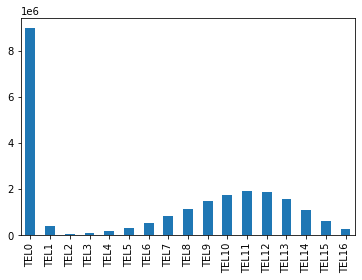

In [77]:
telseq_row.plot(kind='bar')

In [78]:
telseq_tot=0
for c in ['TEL6', 'TEL7', 'TEL8', 'TEL9', 'TEL10', 'TEL11', 'TEL12', 'TEL13',
       'TEL14', 'TEL15', 'TEL16']:
    telseq_tot+=telseq_row[c]

In [79]:
telseq_telcontent=telseq_tot/TOTAL_READS

In [80]:
print(f'TelSeq telomere content (n=6 or more): {telseq_telcontent*100}%')

TelSeq telomere content (n=6 or more): 56.29548924544662%


## Computel


[Computel: measuring telomere length and telomeric repeat variant composition from WGS data](http://big.sci.am/software/computel/)

[code](https://github.com/lilit-nersisyan/computel)

Nersisyan L, Arakelyan A. Computel: computation of mean telomere length from whole-genome next-generation sequencing data. PLoS One 2015, 10(4):e0125201. [link](https://pubmed.ncbi.nlm.nih.gov/25923330/)

Installed as per [instructions](http://big.sci.am/software/computel/)

Used defaults

./computel.sh -1 /mnt/1TB_0/Data/RaTG13/data/Sars_SL3_R1_171127.fastq -2 /mnt/1TB_0/Data/RaTG13/data/Sars_SL3_R2_171127.fastq -p 20 -o /mnt/1TB_0/Data/RaTG13/analysis/computel

In [98]:
df_computel_stats=pd.read_csv(DATA_PATH+'computel/Human/tel.length.csv', sep='\t')

In [99]:
df_computel_stats.head(n=10)

,Parameter,Value
0,coverage.file,/mnt/1TB_0/Data/RaTG13/analysis/computel/Human...
1,reads,/mnt/1TB_0/Data/RaTG13/data/Sars_SL3_R1_171127...
2,read.length,150
3,pattern.length,c(pattern = 6)
4,base.cov,1.0729794335837
5,num.haploid.chr,23
6,tel.length,c(pattern = 11230598.3177069)
7,genome.length,3244610000
8,min.seed,12


In [88]:
df_computel=pd.read_csv(DATA_PATH+'computel/Human/tel.variants.csv', sep='\t')

In [89]:
df_computel.head(n=10)

,pattern,abs num,% of all patterns,% of variants
0,TTAGGG,29908455,68.698760,0.000000
1,ATAGGG,3074060,7.061017,22.558266
2,TTGGGAACAGG,1043957,2.397936,7.660833
3,GTTAGG,904578,2.077787,6.638033
4,AACAGG,798553,1.834251,5.859993
5,TTAGGT,789406,1.813240,5.792870
6,TTGGAAACAGG,636873,1.462877,4.673543
7,TTAGG,583450,1.340166,4.281511
8,TTAGTG,474740,1.090463,3.483768
9,GTTGGG,437589,1.005128,3.211144


## Motif Counter

[link](https://sourceforge.net/projects/motifcounter/)
    
    "Motif counter is a simple bash script that allows users to scan all reads contained in a bam file for a specific motif sequence repeated a number of times. Designed to look for the number of variant telomere repeats and reads in a whole genome sequencing dataset. The program prompts for a character string, and the number of times that string should be present in each read, then pulls out the data. Motifs can either be consecutive or uncoupled from each other across the read, and analysis endpoints include read number and percentage tables, compiled bam files with only motif-containing reads, or bam files with motif-containing reads together with their paired end."

Used the following parameters:

```
-> Please input sequence motif to search:  TTAGGG
-> Please input number of repeats:  6
```


#### Uncoupled

```
bash motif_counter.sh  -s -u -q 0
```

In [176]:
df_mc=pd.read_csv(DATA_PATH+'motif_counter/motiff_counter_out_s_u_q0.txt', sep='\t')
df_mc.head()

,INDEX,Reads_(q>0),6xTTAGGG_uncoupled,Percent_fwd_uncoupled,6xCCCTAA_uncoupled,Percent_rev_uncoupled,6xTTAGGG_total_uncoupled,Percent_total_uncoupled,Unnamed: 8,Unnamed: 9
0,Sars_SL3_171127_gatk_sorted_marked.bam,23209334,6581192,28.355799,6636486,28.594039,13217678,56.949838,NaN,NaN
